## Modelizacion Predictiva del IBEX35

El IBEX 35 es el índice oficial de la bolsa española compuesto por las 35 empresas más negociadas del mercado. Este índice nos muestra en tiempo real si los precios en bolsa están subiendo o bajando, por lo que permite medir el comportamiento de este conjunto de acciones.

El IBEX35 sirve como punto de referencia para los inversores del mercado español. La rentabilidad de este índice es el objetivo a batir por los gestores.

Por lo tanto, la modelización de las dinámicas de este tipo de índices resultan esenciales para la toma de decisiones por parte de todas las entidades bursátiles.

**Las variables predictoras que se presentan son:**

- Date: Día al que hacen referencia los datos presentados.
- Open: Precio de apertura de ese día.
- High: Precio máximo alcanzado durante ese día.
- Low: Precio mínimo alcanzado durante ese día.
- Close: Precio de cierre de ese día ajustado por splits.
- Adj Close: Precio de cierre ajustado por splits y distribuciones de dividendos o plusvalías.
- Volume: El número físico de acciones negociadas del índice bursátil.

La variable objetivo:

**Target**: Esta es la variable a predecir. Es una variable binaria.

- 1: Indica que el precio de cierre tres días adelante será más alto que el precio de cierre actual.
- 0: Indica que el precio de cierre tres días adelante será igual o menor al precio actual.

In [1]:
import pandas as pd
import numpy as np
import shap
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [ ]:
!python -m spacy download es_core_news_md

Cargar la serie de tiempo para modelar los datos:

In [5]:
data = (
    pd.read_csv('data/train.csv')
    .astype({"Date": "datetime64[ns]"})
    .sort_values(by=["Date"])
    .reset_index()
    .rename(columns={"index": "time_step", "Date":"date"})
    .set_index("date")
    .resample("D").mean() # ya esta por dia pero hacemos esto para que no haya problemas con los indices
    .dropna()
)
data

,time_step,Open,High,Low,Close,Adj Close,Volume,Target
date,,,,,,,,
1994-01-03,0.0,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0.0
1994-01-04,1.0,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1.0
1994-01-05,2.0,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1.0
1994-01-07,4.0,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1.0
1994-01-10,5.0,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1.0
...,...,...,...,...,...,...,...,...
2019-05-24,6549.0,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0.0
2019-05-27,6550.0,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0.0
2019-05-28,6551.0,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0.0


Cargar los datos de Tweets

In [6]:
tweets_df = (
    pd.read_csv('data/tweets_from2015_#Ibex35.csv')
    .assign(tweetDate=lambda x: pd.to_datetime(x['tweetDate'], format='%a %b %d %H:%M:%S +0000 %Y',errors='coerce'))
    .dropna()
    # .drop(columns="handle") # el nombre de perfil de usuario es irrelevante
    .assign(date=lambda x: x['tweetDate'])
    .set_index("date")
)
tweets_df

,tweetDate,handle,text
date,,,
2022-04-09 14:47:45,2022-04-09 14:47:45,abelac62,He hecho el repaso de todos los componentes de...
2022-04-07 19:14:36,2022-04-07 19:14:36,LluisPerarnau,Els projectes que han presentat les empreses d...
2022-04-04 16:48:45,2022-04-04 16:48:45,Pegaso121080,"Por si no lo has visto, o no lo encuentras en ..."
2022-04-05 07:23:16,2022-04-05 07:23:16,zonavalue,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...
2022-03-31 16:07:43,2022-03-31 16:07:43,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0..."
...,...,...,...
2015-01-08 16:41:36,2015-01-08 16:41:36,elEconomistaes,"#Cierre | El #Ibex35 sube un 2,26% hasta los 1..."
2015-01-03 17:20:30,2015-01-03 17:20:30,Roger_bolsa,Un vistazo a los #Bluechips del #Ibex #Ibex35....
2015-01-10 19:42:45,2015-01-10 19:42:45,Secretosdebolsa,Así comienza la #Bolsa en #2015 Ojo a los sopo...


### Modelar sin Tweets:

In [7]:
# hacer corte de entrenamiento y testeo que tome el ultimo 15% de los datos
cutoff_point = data.iloc[-int(len(data) * 0.15)].time_step
train_df, test_df = data[data.time_step < cutoff_point], data[data.time_step >= cutoff_point]
X_train, y_train = train_df.drop(columns="Target"), train_df.Target
X_test, y_test = test_df.drop(columns="Target"), test_df.Target

Se usa el modelo de gradient-boosting `lightgbm` para modelar los datos

In [8]:
mod = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=32,
    colsample_bytree=0.8,
    subsample=0.8,
    max_depth=7,
    random_state=42,
)

In [10]:
# entrenar y evaluar sin variables extra
mod.fit(X_train, y_train)
preds = mod.predict(X_test)
print(f"F1 score: {f1_score(y_test, preds):.3f}")

F1 score: 0.419


Haciendo extraccion de features temporales (rolling, lag, etc)

In [11]:
# con variables extra
from src import features
feature_cols = ["Open"]
features_args = dict(num_lags=3, roll_nums=(7,15,30))
filter = "^((?!Volume.*).)*$"
train_features = features.make_features(X_train, feature_cols, **features_args).filter(regex=filter)
test_features = features.make_features(X_test, feature_cols, **features_args).filter(regex=filter)
print("Numero de features:", train_features.shape[1])

mod.fit(train_features, y_train.loc[train_features.index])
preds = mod.predict(test_features)
print(f"F1 score: {f1_score(y_test.loc[test_features.index], preds):.3f}")

Numero de features: 21
F1 score: 0.556


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


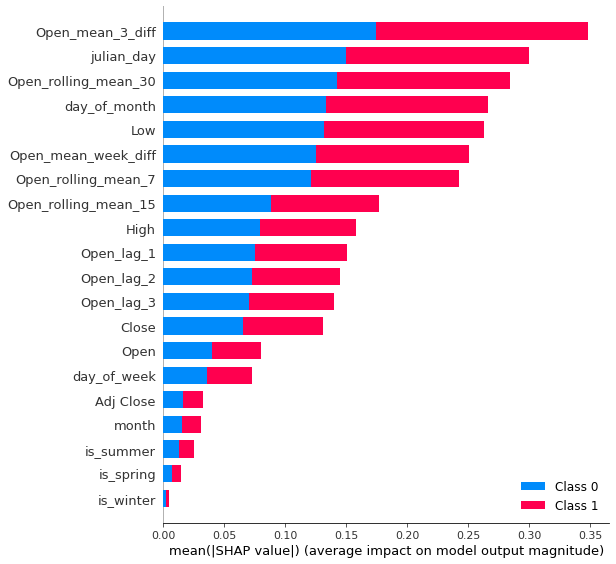

In [12]:
# importancia de cada variable con shap
shap_values = shap.TreeExplainer(mod).shap_values(test_features)
shap.summary_plot(shap_values, test_features)

----

### Incorporando Tweets

Se usa spacy para añadir los word embeddings de tweets como variables predictoras adicionales.

In [14]:
import spacy
from termcolor import colored
from sklearn.decomposition import PCA
import src.text_processing as text
# juntamos todos los tweets por el dia en que fueron publicados
tweets_per_day = tweets_df[["text"]].resample("D").agg(lambda x: ' '.join(x).lower())
tweets_per_day["num_tweets"] = tweets_df[["text"]].resample("D").size()
tweets_per_day

,text,num_tweets
date,,
2015-01-03,un vistazo a los #bluechips del #ibex #ibex35....,1
2015-01-04,.@monicamelle escasamente entusiasta sobre el ...,1
2015-01-05,"tras un arranque en negativo, el #ibex35 retom...",5
2015-01-06,tomad capitalismo! #españa los dueños del #ibe...,3
2015-01-07,"el #ibex35 rebota el 1,5% y toca los 10.000 pu...",1
...,...,...
2022-04-05,📈 #bolsa: el #ibex35 abre en 🟢 \n\n🇪🇸 #ibex35 ...,2
2022-04-06,"#ibex35 recorte dentro de lo admisible, canal ...",1
2022-04-07,"⚠️a pesar de la crisis y la pandemia, un 40% ...",4


In [15]:
# preprocesamiento de los tweets (eliminamos stopwords, tokenizamos, etc)
nlp = spacy.load('es_core_news_md')
valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])

tweets_per_day["processed"] = (
    tweets_per_day.text
    .pipe(text.tokenize, nlp)
    .pipe(text.drop_symbols)
    .pipe(text.drop_stopwords)
    .pipe(text.filter_pos, valid_POS)
    .pipe(text.lemmatize)
    .pipe(text.tokenize, nlp)
)

# ejemplo de procesado de texto
print(f"Tweet antes de procesar:\n{colored(tweets_per_day.text.iloc[-1],'blue')}")
print(f"Tweet despues de procesar:\n{colored(tweets_per_day.processed.iloc[-1],'green')}")


Tweet antes de procesar:
💶¿quiénes "se forraron" en 2021, en medio de la gran crisis sanitaria, económica y social?: 
💲las petroleras, las eléctricas y las gasísticas
👎@manolomarrerom:"las seis empresas energéticas del #ibex35 ganaron en 2021 un total de 10.117 millones de euros.eso es una obscenidad" https://t.co/ys6ydjimby he hecho el repaso de todos los componentes del #ibex35 y ahora me pongo con lo de la chiqui. si mañana tengo tiempo, publicaré algún activo interesante del mercado europeo y americano. buen fin de semana.
Tweet despues de procesar:
forrar crisis sanitario económico social petrolera eléctrico gasística empresa energético ganar millón obscenidad repaso componente poner chiqui tiempo publicar activo interesante mercado europeo americano semana


In [54]:
# obtener word embeddings de los tweets de cada día
tweet_embeddings = tweets_per_day.processed.apply(lambda doc: doc.vector)
# numero de tokens/palabras por dia
tweets_per_day["num_tokens"] = tweets_per_day.processed.apply(lambda doc: len(doc))
# hacer PCA para reducir el numero de features de los embeddings
embeddings_arr = np.stack(tweet_embeddings.values)
# solo 10 componentes para añadirlas luego como features
pca = PCA(n_components=10)
embeddings_arr_pca = pca.fit_transform(embeddings_arr)
print(f"{pca.n_components} componentes principales explican {pca.explained_variance_ratio_.sum()*100:.2f}% de la varianza de los word-embeddings")
embeddings_df = pd.DataFrame(embeddings_arr_pca, index=tweet_embeddings.index, columns=["tweet_embed_"+str(i+1) for i in range(pca.n_components)])
embeddings_df

10 componentes principales explican 61.73% de la varianza de los word-embeddings


,tweet_embed_1,tweet_embed_2,tweet_embed_3,tweet_embed_4,tweet_embed_5,tweet_embed_6,tweet_embed_7,tweet_embed_8,tweet_embed_9,tweet_embed_10
date,,,,,,,,,,
2015-01-03,0.470104,7.263266,1.212202,1.470478,-2.522190,-0.044917,-0.782136,2.139297,-1.393850,-0.481136
2015-01-04,-4.822864,-1.157155,-4.787719,-2.749020,-0.716836,-1.368823,2.090041,-0.079291,-1.919087,1.674568
2015-01-05,-4.662891,-1.135178,1.849361,-2.740112,2.925275,0.445988,-0.709622,0.292815,0.180277,-1.300653
2015-01-06,-0.774262,-1.590158,2.463738,-1.070516,2.419477,3.180981,0.701007,-2.426113,-0.335522,0.395181
2015-01-07,0.254174,-6.457656,6.478698,1.788517,1.150227,-4.142327,-2.256922,0.258743,0.336120,-1.160732
...,...,...,...,...,...,...,...,...,...,...
2022-04-05,-4.698101,-0.226461,4.218924,0.749429,-0.212645,0.405166,-1.560254,-0.175672,-0.364285,1.062407
2022-04-06,-6.029510,-0.341921,0.287270,-3.720592,2.488770,-0.749909,-0.115492,-0.197408,-0.099122,-0.946593
2022-04-07,0.241657,3.482694,-1.671106,1.618514,5.994866,-1.098094,0.342078,-0.779168,-0.967932,3.429768


In [68]:
# solo evaluaremos en los datos donde han habido tweets
ts_with_tweets = data.loc[data.index.isin(tweets_per_day.index)]
# y evaluamos de la misma manera que antes
cutoff_point = ts_with_tweets.iloc[-int(len(ts_with_tweets) * 0.15)].time_step
train_df, test_df = ts_with_tweets[ts_with_tweets.time_step < cutoff_point], ts_with_tweets[ts_with_tweets.time_step >= cutoff_point]
X_train, y_train = train_df.drop(columns=["time_step","Target"]), train_df.Target
X_test, y_test = test_df.drop(columns=["time_step","Target"]), test_df.Target

In [69]:
# sin extras
mod.fit(X_train, y_train)
preds = mod.predict(X_test)
print(f"F1 score: {f1_score(y_test, preds):.3f}")

F1 score: 0.521


In [70]:
# solo con variables extra 
feature_cols = ["Open"]
train_features = features.make_features(X_train, feature_cols, **features_args).filter(regex=filter)
test_features = features.make_features(X_test, feature_cols, **features_args).filter(regex=filter)

mod.fit(train_features, y_train.loc[train_features.index])
preds = mod.predict(test_features)
print(f"F1 score: {f1_score(y_test.loc[test_features.index], preds):.3f}")

F1 score: 0.535


In [71]:
# solo con word embeddings
train_features = embeddings_df.loc[embeddings_df.index.isin(X_train.index)]
test_features = embeddings_df.loc[embeddings_df.index.isin(X_test.index)]
print("Numero de features:", train_features.shape)

# ver como mejora con los embeddings
mod.fit(train_features, y_train.loc[train_features.index])
preds = mod.predict(test_features)
print(f"F1 score: {f1_score(y_test.loc[test_features.index], preds):.3f}")

Numero de features: (957, 10)
F1 score: 0.542


In [73]:
# con variables extra + word embeddings
train_features = features.make_features(X_train, feature_cols, **features_args).filter(regex=filter)
test_features = features.make_features(X_test, feature_cols, **features_args).filter(regex=filter)
train_features_embed = train_features.join(embeddings_df)
test_features_embed = test_features.join(embeddings_df)

print("Numero de features:", train_features_embed.shape)
# ver como mejora con los embeddings
mod.fit(train_features_embed, y_train.loc[train_features_embed.index])
preds = mod.predict(test_features_embed)
print(f"F1 score: {f1_score(y_test.loc[test_features_embed.index], preds):.3f}")

Numero de features: (928, 30)
F1 score: 0.584


In [74]:
# con variables extra + word embeddings + variables basadas en numero de tweets y tokens
tweets_features = tweets_per_day[["num_tweets","num_tokens"]].copy()
tweets_features["num_tweets_lag_3"] = tweets_per_day.num_tweets.shift(3)
tweets_features["num_tweets_lag_7"] = tweets_per_day.num_tweets.shift(7)
tweets_features["num_tokens_lag_3"] = tweets_per_day.num_tokens.shift(3)
tweets_features["num_tokens_lag_7"] = tweets_per_day.num_tokens.shift(7)
tweets_features = tweets_features.dropna()

train_features = features.make_features(X_train, feature_cols, **features_args).filter(regex=filter)
test_features = features.make_features(X_test, feature_cols, **features_args).filter(regex=filter)

train_features_embed = train_features.join(embeddings_df).join(tweets_features).dropna()
test_features_embed = test_features.join(embeddings_df).join(tweets_features).dropna()

print("Numero de features:", train_features_embed.shape)
# ver como mejora con los embeddings
mod.fit(train_features_embed, y_train.loc[train_features_embed.index])
preds = mod.predict(test_features_embed)
print(f"F1 score: {f1_score(y_test.loc[test_features_embed.index], preds):.3f}")

Numero de features: (928, 36)
F1 score: 0.630


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


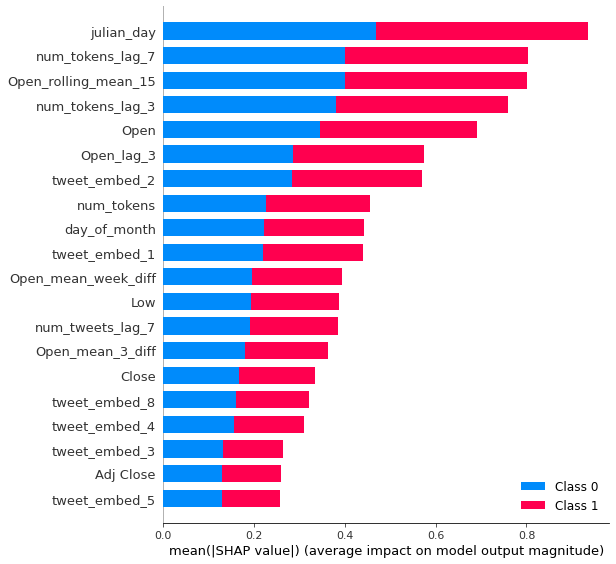

In [75]:
# importancia de cada variable con shap
shap_values = shap.TreeExplainer(mod).shap_values(test_features_embed)
shap.summary_plot(shap_values, test_features_embed)

In [76]:
# Volver a fitear con todos los datos (entrenamiento + test)
features_embed = pd.concat([train_features_embed, test_features_embed], axis=0)
y = pd.concat([y_train, y_test], axis=0)
mod.fit(features_embed, y.loc[features_embed.index])

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, max_depth=7,
               n_estimators=500, num_leaves=32, random_state=42, subsample=0.8)

------

Prediccion Final de Entrega:

In [79]:
test_x = (
    pd.read_csv("data/test_x.csv")
    .astype({"Date": "datetime64[ns]"})
    .sort_values(by=["Date"])
    .reset_index()
    .rename(columns={"index": "time_step", "Date":"date"})
    .set_index("date")
    .resample("D").mean() # ya esta por dia pero hacemos esto para que no haya problemas con los indices
    .dropna(how="all")
)
# crear features del conjunto de entrega
feature_cols = ["Open"]
full_df = pd.concat([data, test_x.drop(columns=["test_index"])], axis=0).drop(columns=["Target","time_step"])
full_df_features = features.make_features(full_df, feature_cols, **features_args).filter(regex=filter)
full_features_embed = full_df_features.join(embeddings_df).join(tweets_features).dropna()
X_entrega = full_features_embed.loc[full_features_embed.index.isin(test_x.index)]
# predecir
pred_entrega = mod.predict(X_entrega)

In [80]:
entrega_df = pd.DataFrame({"test_index": test_x.test_index, "Target": pred_entrega}).astype(int).set_index("test_index")
entrega_df

,Target
test_index,
6557,0
6558,0
6559,0
6560,0
6561,0
...,...
7278,1
7279,1
7280,1


In [51]:
# guardar predicciones como csv y como json
entrega_df.to_csv("predictions.csv", index=True)
entrega_df.to_json("predictions.json")

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


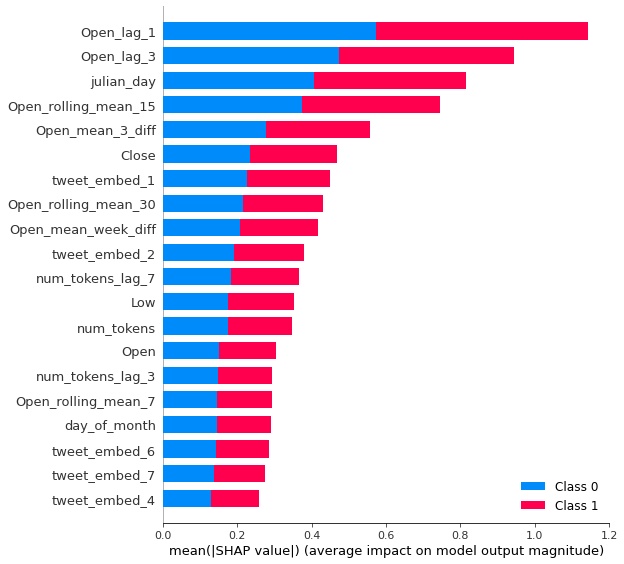

In [ ]:
# importancia de cada variable con shap
shap_values = shap.TreeExplainer(mod).shap_values(X_entrega)
shap.summary_plot(shap_values, X_entrega)